## This notebook contains solutions to exercises 1, 2, 3, 10, 12 in Data analysis recipies: Fitting a model to data by David Hogg, Jo Bovy, and Dustin Lang.

# Exercise 1: 
Use the standard linear algebra from Section 1. to fit the straight line $y = mx + b$ to the $x$, $y$, and $sigma_y$ values provided in the file `hogg-table1.txt`. We ignore the first four data points in the table.

In [45]:
# general imports for all coming exercises
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set new color cycler
from cycler import cycler
import matplotlib as mpl
import plotly.express as px

# Types
from typing import TypeAlias
Matrix: TypeAlias = np.ndarray
Vector: TypeAlias = np.ndarray

mpl.rcParams["axes.prop_cycle"] = cycler(color=px.colors.qualitative.Plotly)
mpl.rcParams["text.usetex"] = True

TABLE_FILE = Path("hogg-table1.txt")
table = np.loadtxt(TABLE_FILE, usecols=(1, 2, 3, 4, 5), unpack=True)


We start by aranging the data in the table in to the vectors/matrices:
\begin{align*}
    \boldsymbol{Y} &= \begin{bmatrix}
        y_1 \\
        y_2 \\
        \dots \\ 
        y_N
    \end{bmatrix}, \\
    \boldsymbol{A} &= \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
        1 & \dots \\ 
        1 & x_N
    \end{bmatrix}, \\
        \boldsymbol{C} &= \begin{bmatrix}
        \sigma^2_{y_1} & 0 & \dots & 0 \\
        0 &  \sigma^2_{y_2} & \dots & 0 \\
        & & \dots & & \\
        0 & 0 & \dots & \sigma^2_{y_N} \\
    \end{bmatrix}
\end{align*}

In [46]:
X, Y, sigma_y = table[:, 5:][0:3] # columns for x, y, and sigma_y

A = np.vstack([np.ones(len(X)), X]).T
C = np.diag(sigma_y**2)

We can then solve the normal equations:

\begin{align*}
    \begin{bmatrix}
        b \\ m
    \end{bmatrix}
     = \boldsymbol{X} = \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1} \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{Y} \right]
\end{align*}

In [ ]:
def solve_normal_equations(A: Matrix, C: Matrix, Y: Vector) -> Vector:
    

In [47]:
C_inv = np.linalg.inv(C)
sigma_inv = np.linalg.inv(A.T @ C_inv @ A)
b, m = sigma_inv @ (A.T @ C_inv @ Y) # best fit intercept (b) and slope (m)
b, m

(34.845941313398725, 2.2325362169534166)

We plot the data and the best fit line $y = mx + b$:

Text(0, 0.5, '$y$')

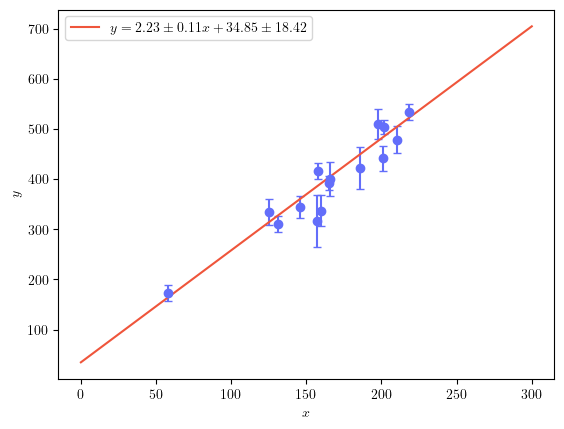

In [52]:
x = np.linspace(0, 300, 20) 
y_hat = m * x + b # best fit line

sigma_b, sigma_m = np.sqrt(sigma_inv.diagonal()) # standard deviation of the intercept and slope

plt.errorbar(X, Y, yerr=sigma_y, fmt="o", capsize=3)
plt.plot(x, y_hat, label=rf"$y = {{{m:.2f}}} \pm {{{sigma_m:.2f}}}x + {b:.2f} \pm {{{sigma_b:.2f}}}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

## Exercise 2:

We repeat the above calculating but for all the data points in the original table

In [54]:
X, Y, sigma_y = table[0:3] # columns for x, y, and sigma_y

A = np.vstack([np.ones(len(X)), X]).T
C = np.diag(sigma_y**2)
C_inv = np.linalg.inv(C)
sigma_inv = np.linalg.inv(A.T @ C_inv @ A)
b, m = sigma_inv @ (A.T @ C_inv @ Y) # best fit intercept (b) and slope (m)
b, m

(213.2734919759614, 1.0767475241683258)

Text(0, 0.5, '$y$')

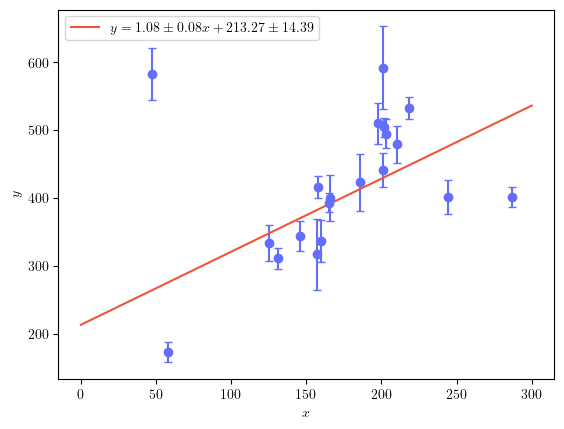

In [55]:
x = np.linspace(0, 300, 20) 
y_hat = m * x + b # best fit line

sigma_b, sigma_m = np.sqrt(sigma_inv.diagonal()) # standard deviation of the intercept and slope

plt.errorbar(X, Y, yerr=sigma_y, fmt="o", capsize=3)
plt.plot(x, y_hat, label=rf"$y = {{{m:.2f}}} \pm {{{sigma_m:.2f}}}x + {b:.2f} \pm {{{sigma_b:.2f}}}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

The new data points are some pretty big outliers which result in half as big of a slope. 

Generalize the method of this Section to fit a general quadratic
(second order) relationship. Add another column to matrix A containing the
values x2
i , and another element to vector X (call it q). Then re-do Exercise 1
but fitting for and plotting the best quadratic relationship
g(x) = q x2 + m x + b . (8)
Your plot should end up looking like Figure 3.

## Exercise 3:
We will now repeat the fit in exercise one but with a quadratic equation on the form $g(x) = q x^2 + m x + b$. We can do so by adding another column to the matrix $\boldsymbol{A}$ which contains the $x^2$ values:

\begin{align}
    \boldsymbol{A} &= \begin{bmatrix}
        1 & x_1 & x_2 \\
        1 & x_2 & x_2 \\
        1 & \dots & \dots \\ 
        1 & x_N & x_2
    \end{bmatrix}. \\
\end{align}

Solving the normal equations now give us an additional fit for $q$:

\begin{align*}
    \begin{bmatrix}
        b \\ m \\ q
    \end{bmatrix}
     = \boldsymbol{X} = \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1} \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{Y} \right]
\end{align*}